In [27]:
import pandas as pd
df=pd.read_csv("../data/fake_and_real_news_final.csv")

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df = df.sample(frac=1)
df = df.dropna(subset=['clean_text', 'label'])

X = df["clean_text_lower"]
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)


pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(2,3), min_df=10, max_df=0.95)),
    ('multinomialnb', MultinomialNB(alpha=1))
])


pipeline.fit(X_train, y_train)


y_pred= pipeline.predict(X_test)
y_pred_train= pipeline.predict(X_train)


In [39]:
from sklearn.metrics import roc_auc_score


y_proba = pipeline.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_proba)

print(f"ROC AUC Score: {auc_score:.4f}")


ROC AUC Score: 0.9906


In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
report = classification_report(y_test, y_pred)
print("Classification Report (Test):\n", report)

report = classification_report(y_train, y_pred_train)
print("Classification Report (Train):\n", report)

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      6859
           1       0.96      0.98      0.97      6359

    accuracy                           0.97     13218
   macro avg       0.97      0.97      0.97     13218
weighted avg       0.97      0.97      0.97     13218

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     15991
           1       0.97      0.98      0.98     14851

    accuracy                           0.98     30842
   macro avg       0.98      0.98      0.98     30842
weighted avg       0.98      0.98      0.98     30842



In [31]:
df[['text','label']].sample(4)

,text,label
27364,DUBAI (Reuters) - Yemen s ex-president Ali Abd...,1
11526,Why is explaining our Constitution to liberals...,0
39628,In a speech weighted with America’s complicate...,1
19143,CAIRO (Reuters) - Egypt has arrested 22 people...,1


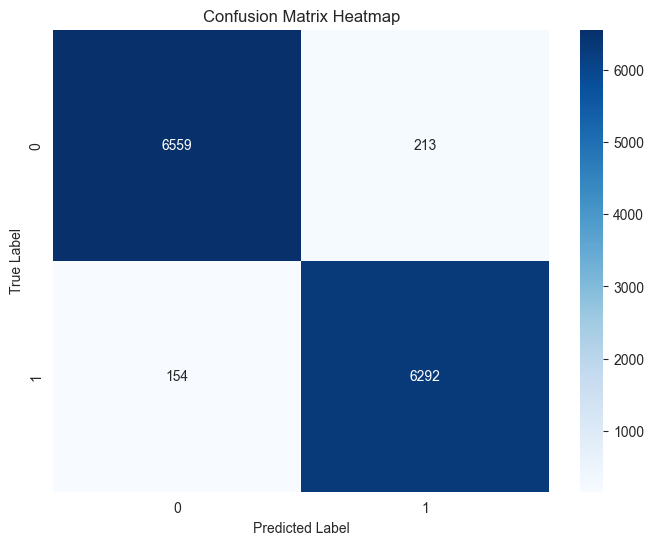

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


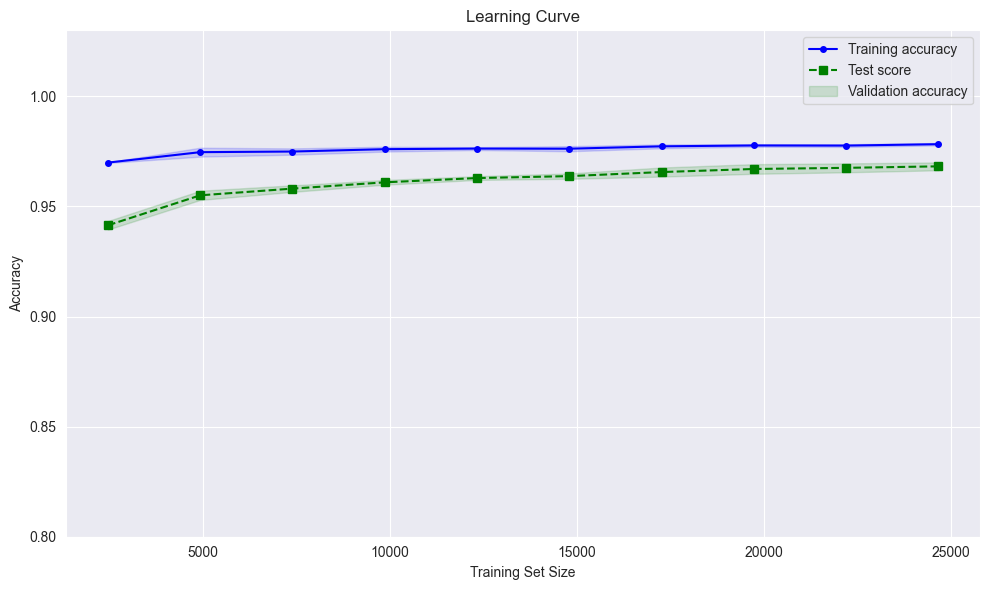

In [33]:
from sklearn.model_selection import learning_curve,train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(2,3), min_df=10, max_df=0.95)),
    ('multinomialnb', MultinomialNB(alpha=1))
])

X = df["clean_text"].astype(str)
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=0)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,       
    X=X_train,          
    y=y_train,           
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5,              
    scoring='accuracy', 
    n_jobs=10          
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))


plt.plot(train_sizes, train_mean, label="Training accuracy", color='blue', marker='o',markersize='4')
plt.fill_between(train_sizes,
train_mean + train_std,
train_mean - train_std,
alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, label="Test score", color='green',marker='s',linestyle='--')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green',label='Validation accuracy')


plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.ylim([0.8, 1.03])
plt.grid(True)
plt.tight_layout()
plt.show()



In [34]:
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(3,4), min_df=10, max_df=0.95)),
    ('multinomialnb', MultinomialNB(alpha=0.5))
])

X = df["clean_text"].astype(str)
y = df["label"]

params =[0.01, 0.1, 0.5, 1.0, 2.0, 5.0,10.0]

train_scores, test_scores = validation_curve(
estimator=pipeline,
X=X_train,
y=y_train,
param_name='multinomialnb__alpha',
param_range=params,
cv=5,
n_jobs=6
)



train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(params, train_mean,
color='blue', marker='o',
markersize=5, label='Training accuracy')
plt.fill_between(params, train_mean + train_std,
train_mean - train_std, alpha=0.15,
color='blue')
plt.plot(params, test_mean,
color='green', linestyle='--',
marker='s', markersize=5,
label='Validation accuracy')

plt.fill_between(params,
test_mean + test_std,
test_mean - test_std,
alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

KeyboardInterrupt: 

In [24]:
import joblib
joblib.dump(pipeline, './news_classifier_pipeline.pkl')

['./news_classifier_pipeline.pkl']

In [25]:
# import numpy as np
# from sklearn.model_selection import train_test_split, cross_val_score, KFold
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import GridSearchCV
# 
# 
# df = df.sample(frac=1)
# df = df.dropna(subset=['clean_text', 'label'])
# 
# 
# X = df["clean_text"]
# y = df["label"]
# 
# pipe= make_pipeline(CountVectorizer(),MultinomialNB())
# print(pipe)
# 
# param_grid = {
#     'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'countvectorizer__min_df': [1, 2, 3, 5],
#     'countvectorizer__max_df': [0.85, 0.9, 0.95, 1.0],
#     'countvectorizer__stop_words': ['english', None],
#     'countvectorizer__max_features': [None, 5000, 10000],
#     'multinomialnb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
# }
# 
# grid = GridSearchCV(pipe, param_grid, cv=5,verbose=3)
# grid.fit(X_train, y_train)
# print("Best estimator:\n{}".format(grid.best_estimator_))
# best_model = grid.best_estimator_
# 
# import pandas as pd
# 
# results = pd.DataFrame(grid.cv_results_)
# results['param_countvectorizer__ngram_range'] = results['param_countvectorizer__ngram_range'].astype(str)
# 
# heatmap_data = results.pivot_table(
#     index='param_multinomialnb__alpha',
#     columns='param_countvectorizer__ngram_range',
#     values='mean_test_score'
# )
# 
# import seaborn as sns
# import matplotlib.pyplot as plt
# 
# plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
# plt.title("Grid Search Accuracy Heatmap")
# plt.ylabel("Alpha")
# plt.xlabel("N-gram Range")
# plt.tight_layout()
# plt.show()
